# Training: Quantum case

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 130
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../data/restaurant_v2_train.txt')
val_labels, val_data = read_data('../data/restaurant_v2_dev.txt')
test_labels, test_data = read_data('../data/restaurant_v2_test.txt')

In [4]:
train_data[:5]

['I love the restaurant',
 'I dislike the restaurant',
 'I loved the great food',
 'I loved the nice food',
 'I loved the tasty food']

In [5]:
train_labels[:5]

[[1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]

### Creating and parameterising diagrams

In [6]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Filter and simplify diagrams

In [7]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Let's see the form of the diagram for a relative clause on the subject of a sentence:

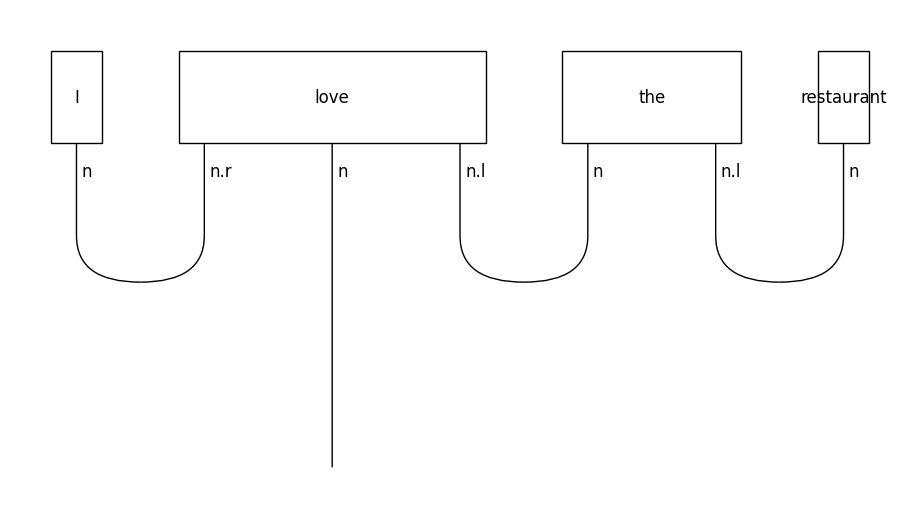

In [8]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In object-based relative clauses the noun that follows the relative pronoun is the object of the sentence:

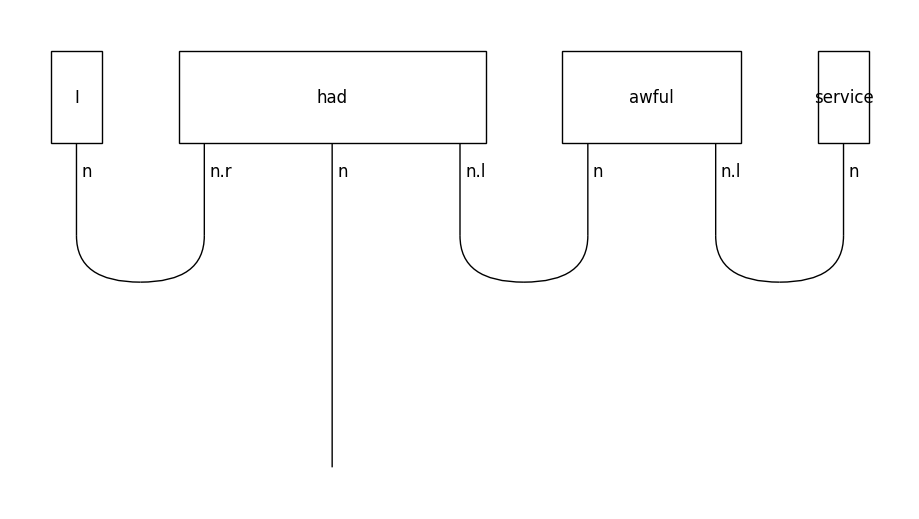

In [9]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

### Create circuits

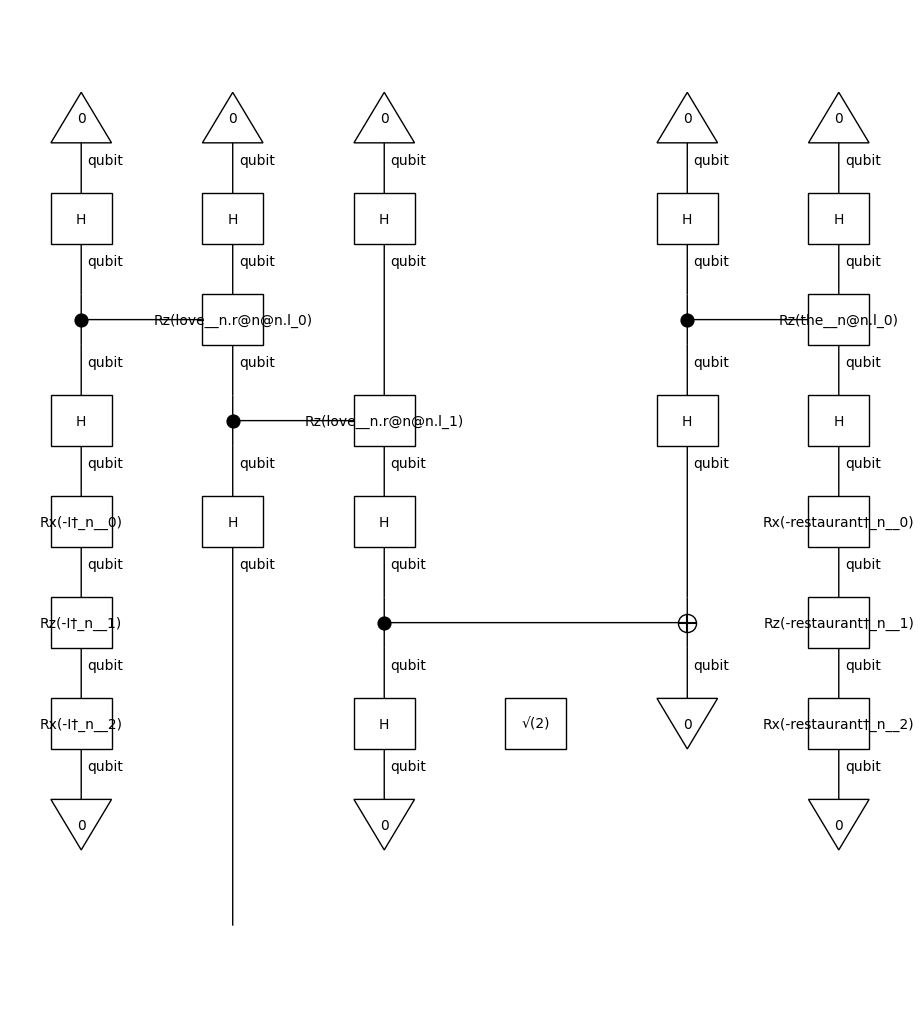

In [10]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Training

### Create Noisy Model

In [11]:
import qiskit_aer.noise as noise

# Define qubits
qubits = range(1)

# Define a noise model that applies uniformly to the given qubits
noise_model = noise.NoiseModel()
dep_err = noise.depolarizing_error(0.01, 1)
ro_err = noise.ReadoutError([[0.9, 0.1], [0.1, 0.9]])

# Add depolarizing error to single-qubit gates on each qubit
for i in qubits:
    noise_model.add_quantum_error(dep_err, ["u1", "u2", "u3"], [i])

# Add readout error for each qubit
for i in qubits:
    noise_model.add_readout_error(ro_err, qubits=[i])

### Instantiate the model

In [12]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits + test_circuits

backend = AerBackend(noise_model=noise_model)
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192,
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

### Define loss and evaluation metric

In [13]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

### Initialise trainer

In [14]:
from lambeq import QuantumTrainer, NelderMeadOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=NelderMeadOptimizer,
    optim_hyperparams={},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

### Create datasets

In [15]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [16]:
trainer.fit(train_dataset, val_dataset, minimize_criterion=False)

Epoch 1:    train/loss: 0.5339   valid/loss: 5.2738   train/acc: 0.5132   valid/acc: 0.4500
Epoch 2:    train/loss: 0.5087   valid/loss: 7.1878   train/acc: 0.5197   valid/acc: 0.4833
Epoch 3:    train/loss: 0.5087   valid/loss: 8.3817   train/acc: 0.4803   valid/acc: 0.5333
Epoch 4:    train/loss: 0.5087   valid/loss: 7.2661   train/acc: 0.4605   valid/acc: 0.4333
Epoch 5:    train/loss: 0.5087   valid/loss: 3.8704   train/acc: 0.5000   valid/acc: 0.5833
Epoch 6:    train/loss: 0.5087   valid/loss: 5.1930   train/acc: 0.4474   valid/acc: 0.5667
Epoch 7:    train/loss: 0.2929   valid/loss: 5.8706   train/acc: 0.5066   valid/acc: 0.5167
Epoch 8:    train/loss: 0.2929   valid/loss: 4.6408   train/acc: 0.4671   valid/acc: 0.4000
Epoch 9:    train/loss: 0.2929   valid/loss: 3.9525   train/acc: 0.4539   valid/acc: 0.5167
Epoch 10:   train/loss: 0.2929   valid/loss: 5.7504   train/acc: 0.4737   valid/acc: 0.6333
Epoch 11:   train/loss: 0.2929   valid/loss: 3.9011   train/acc: 0.4934   valid/

## Results

Finally, we visualise the results and evaluate the model on the test data.

Validation accuracy: 0.5


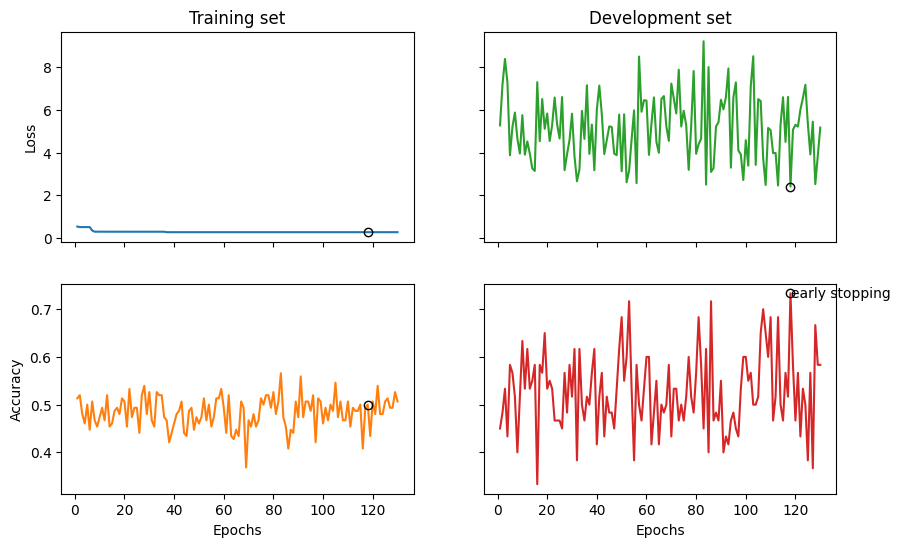

In [17]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.4, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
val_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', val_acc.item())

In [18]:
test_acc = acc(model(test_circuits), test_labels)

# Calculate the loss
predictions = model(test_circuits)
loss = bce(predictions, np.array(test_labels))

print('Test accuracy:', test_acc.item())
print('Test loss:', loss.item())

Test accuracy: 0.5166666666666667
Test loss: 7.755814103719842
